In [1]:
import sys
from pathlib import Path
import os 

PROJECT_ROOT = Path.cwd().parents[0]   # adjust if needed
sys.path.append(str(PROJECT_ROOT))

In [2]:
PROJECT_ROOT

WindowsPath('c:/Users/fperezg/Desktop/papers/period estimation Light curves/code/Comparing_irregular_sampled_time_series_using_JDR/Python files/JDR-python')

In [3]:
from src.metrics import integrate_cross_spectrum_real_R, auto_spectrum_irregular, integrate_cross_spectrum_real
from src.read_data import read_ogle_dat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
PROJECT_ROOT

WindowsPath('c:/Users/fperezg/Desktop/papers/period estimation Light curves/code/Comparing_irregular_sampled_time_series_using_JDR/Python files/JDR-python')

In [5]:
# Choose the files you want
file1 = "../data/OGLE-BLG-RRLYR-00001.dat"
file2 = "../data/OGLE-BLG-RRLYR-00003.dat"
# JDR R 0.001591215
Irrlyr1 = read_ogle_dat(file1)
Irrlyr2 = read_ogle_dat(file2)

#Irrlyr1 = Irrlyr1.sample(300) if len(Irrlyr1) > 300 else Irrlyr1
#Irrlyr2 = Irrlyr2.sample(300) if len(Irrlyr2) > 300 else Irrlyr2


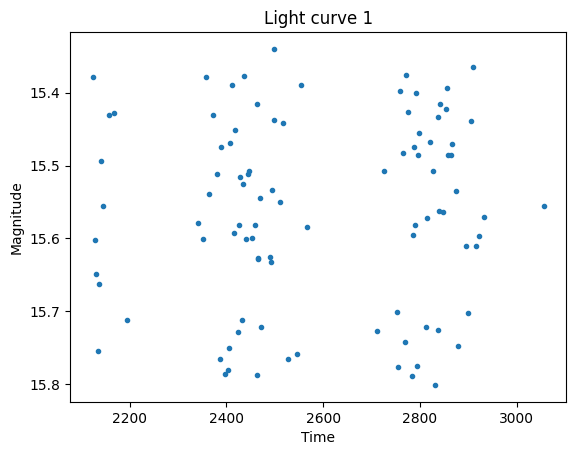

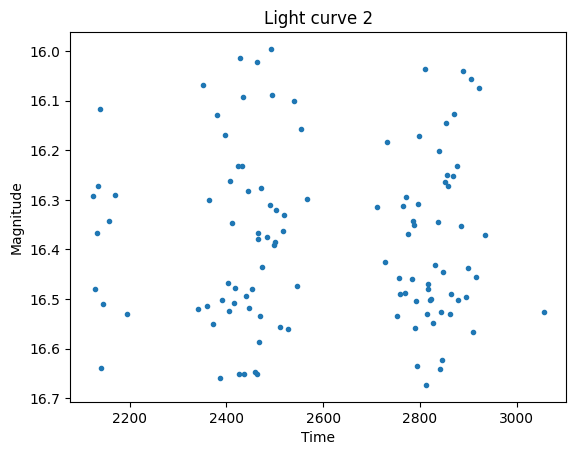

In [6]:

# Column mapping
# time = col 0, magnitude = col 1, error = col 2 (optional)
t1 = Irrlyr1.iloc[:, 0].to_numpy()
x = Irrlyr1.iloc[:, 1].to_numpy()

t2 = Irrlyr2.iloc[:, 0].to_numpy()
y = Irrlyr2.iloc[:, 1].to_numpy()

# Plot series 1
plt.figure()
plt.scatter(t1, x, marker=".")
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.title("Light curve 1")
plt.gca().invert_yaxis()  # common for magnitudes; remove if undesired
plt.show()

# Plot series 2
plt.figure()
plt.scatter(t2, y, marker=".")
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.title("Light curve 2")
plt.gca().invert_yaxis()
plt.show()


In [7]:

# -----------------------------------------------------------
# Global spectral parameters: mixture weight and frequency grid
# -----------------------------------------------------------

alpha = 0.5
beta = alpha * (1 - alpha)


In [8]:

# Approximate average sampling interval Δt (using series 1)
st = t1

delta_t = (np.max(st) - np.min(st)) / len(st)

delta_f = 0.001

f_min = delta_f

f_max = 1.0 / (2.0 * delta_t)

f = np.arange(f_min, f_max + delta_f, delta_f)

omega = 2.0 * np.pi * f



In [9]:

# Diagnostics for each series
delta_t1 = (np.max(t1) - np.min(t1)) / len(t1)
delta_t2 = (np.max(t2) - np.min(t2)) / len(t2)

print(f"delta_t  (global, from series 1): {delta_t}")
print(f"delta_t1 (series 1): {delta_t1}")
print(f"delta_t2 (series 2): {delta_t2}")
print(f"f_min={f_min}, f_max≈{f_max}, #freq={len(f)}")


delta_t  (global, from series 1): 9.812398000000002
delta_t1 (series 1): 9.812398000000002
delta_t2 (series 2): 8.323016160714287
f_min=0.001, f_max≈0.05095594369490515, #freq=51


In [10]:
# -----------------------------------------------------------
# Auto-spectra (power or cross-spectrum with itself)
# -----------------------------------------------------------

# Vector-valued spectra across omega grid
sx1 = auto_spectrum_irregular(omega, t1, x)
sx2 = auto_spectrum_irregular(omega, t2, y)

In [11]:
# Integrals over frequency band
Ix = integrate_cross_spectrum_real_R(f_min, f_max, t1, x, t1, x)
#Iy = integrate_cross_spectrum_real_R(f_min, f_max, t2, y, t2, y,  jacobian="df")

#Ix, Iy
Ix

0.04494727498436433

In [12]:
# Integrals over frequency band
Ix = integrate_cross_spectrum_real(f_min, f_max, t1, x, t1, x,  jacobian="df")
Iy = integrate_cross_spectrum_real(f_min, f_max, t2, y, t2, y,  jacobian="df")



c:\Users\fperezg\Desktop\papers\period estimation Light curves\code\Comparing_irregular_sampled_time_series_using_JDR\Python files\JDR-python\src\metrics.py:363: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  value, _err = quad(integrand, f_lower, f_upper, limit=quad_limit, epsabs=1e-10, epsrel=1e-10)


In [13]:
Ix

0.04514573965412762

In [14]:
# -----------------------------------------------------------
# Cross term: cross-spectrum between series 1 and 2
# -----------------------------------------------------------
f_max_xy = min(f_max, f_max)  # kept for structural similarity to your R
Ixy = integrate_cross_spectrum_real(f_min, f_max_xy, t1, x, t2, y,  jacobian="df")

c:\Users\fperezg\Desktop\papers\period estimation Light curves\code\Comparing_irregular_sampled_time_series_using_JDR\Python files\JDR-python\src\metrics.py:363: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  value, _err = quad(integrand, f_lower, f_upper, limit=quad_limit, epsabs=1e-10, epsrel=1e-10)


In [ ]:
# -----------------------------------------------------------
# Jensen-type spectral divergence between the two series
# -----------------------------------------------------------
J = beta * (Ix + Iy - 2.0 * Ixy) / (2.0 * np.pi)

print("\nResults:")
print(f"Ix  = {Ix}")
print(f"Iy  = {Iy}")
print(f"Ixy = {Ixy}")
print(f"J   = {J}")



Results:
Ix  = 0.04514573965412762
Iy  = 0.04018127433894445
Ixy = 0.0033930645506476836
J   = 0.0004973659638469638


In [ ]:
# plot auto-spectra for inspection
plt.figure()
plt.plot(f, np.real(sx1), label="Re S_xx (series 1)")
plt.plot(f, np.real(sx2), label="Re S_yy (series 2)")
plt.xlabel("Frequency")
plt.ylabel("Real spectrum (arb. units)")
plt.title("Auto-spectra (real parts)")
plt.legend()
plt.show()